# RF_FM1：介入分布 p(y | do(A=a)) の推定 — Random Forest（平均＋スケール＋残差再標本化）vs Flow Matching

## 概要
- 目的：ATE では差が小さくても，分布のテール（歪度・混合比）では差が現れる状況を作り，RF と FM を比較します．
- 内容：DGP（非線形平均＋異分散＋非ガウス混合）を生成し，介入分布（分位点，ヒストグラム等）を評価します．
- 実行：上から順に実行（Run All）してください（学習ループあり）．
- 依存：torch, numpy, scikit-learn, matplotlib（GPU は任意）．
- 出力：ATE/分位点/分布図の比較．

## 実行メモ
- 乱数性があります（seed を固定したい場合は冒頭セルで設定してください）．
- 実行環境：Python 3 系（推奨：3.10+）．GPU は任意です．


device: cuda
propensity quantiles: [0.13157088 0.19438908 0.24686467 0.49792216 0.74859062 0.80202922
 0.86698532]
  FM step  500 | loss 0.9981
  FM step 1000 | loss 0.9470
  FM step 1500 | loss 0.8914
  FM step 2000 | loss 0.7651
  FM step 2500 | loss 0.6508
  FM step 3000 | loss 0.5562
  FM step 3500 | loss 0.4537
  FM step 4000 | loss 0.4267
  FM step 4500 | loss 0.3720
  FM step 5000 | loss 0.3297

=== TRUE ===
ATE_true: 1.3580790227374973
QTE_true: {0.1: 0.30723606952474536, 0.5: 1.3290199984973454, 0.9: 2.451580722843609}

=== RF (mean+scale+std-residual) ===
ATE_hat: 1.3500882185226593  | abs err: 0.007990804214837999
QTE_hat: {0.1: 0.5201172507568361, 0.5: 1.3755514203905974, 0.9: 2.1337446475008583}
W1 do(0): 0.19653026132665727  | W1 do(1): 0.3616874520324747

=== FM (conditional sampler) ===
ATE_hat: 1.3046295642852783  | abs err: 0.053449458452218934
QTE_hat: {0.1: 0.4473928213119507, 0.5: 1.2989587783813477, 0.9: 2.191728353500366}
W1 do(0): 0.15367364006708134  | W1 do(1)

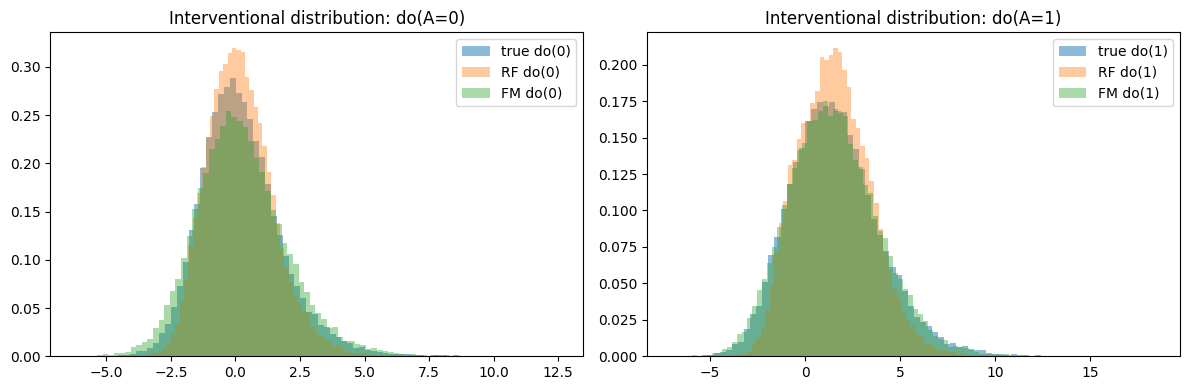

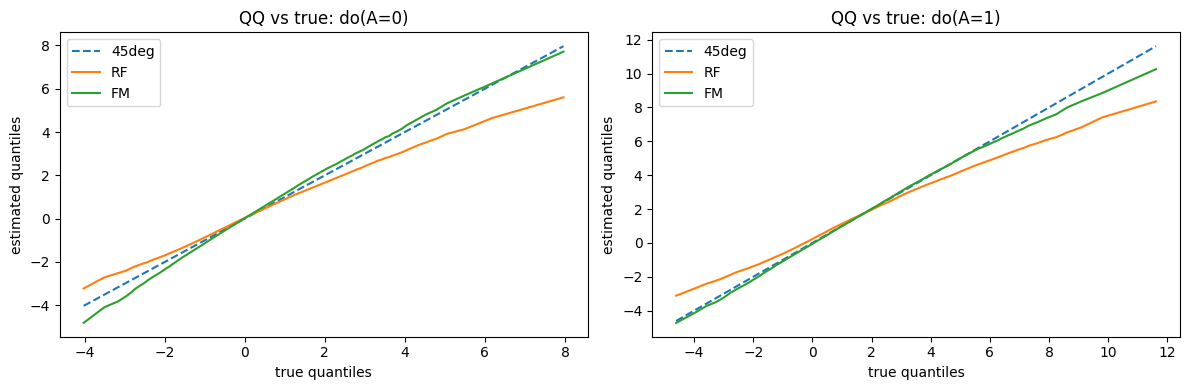

In [1]:
# =========================
# ONE-CELL (book-ready): Marginal interventional distribution benchmark
# Compare: RF (mean+scale+std-residual resampling) vs FM (conditional sampler)
# Metrics: ATE, QTE(alpha=0.1/0.5/0.9), W1 distance for p(y|do(0)), p(y|do(1))
# Plots: histograms + QQ plots for do(0), do(1)
# =========================
# !pip -q install scikit-learn torch

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

# -----------------------
# knobs (調整しやすい)
# -----------------------
SEED = 0
N    = 8000      # observed sample size
D    = 10        # covariate dimension (increase if you want)
N_DO = 40000     # Monte Carlo size for do-distributions (truth & estimates)

ALPHAS = [0.1, 0.5, 0.9]

# DGP strength: distributional effect beyond mean (bigger => easier difference)
STRESS = 1.6

# RF settings
RF_M_TREES   = 800
RF_S_TREES   = 600
RF_MINLEAF_M = 10
RF_MINLEAF_S = 10

# FM settings
FM_STEPS     = 5000
FM_BATCH     = 4096
FM_LR        = 2e-3
FM_HID       = 256
FM_ODE_STEPS = 80

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

# -----------------------
# helpers
# -----------------------
def sigmoid(x): return 1/(1+np.exp(-x))

def w1_1d(a, b, m=6000):
    a = np.asarray(a).ravel()
    b = np.asarray(b).ravel()
    q = np.linspace(0.0, 1.0, m, endpoint=False) + 0.5/m
    aq = np.quantile(a, q)
    bq = np.quantile(b, q)
    return float(np.mean(np.abs(aq - bq)))

def qte(y1, y0, alphas):
    return {a: float(np.quantile(y1, a) - np.quantile(y0, a)) for a in alphas}

# -----------------------
# DGP: confounded A, but ignorability holds given X (by construction)
# Potential outcomes have distributional shift (mixture weight + scale depends on (a,x))
# -----------------------
def f_x(X):
    return (1.0*np.sin(1.2*X[:,0]) + 0.6*(X[:,1]**2-1.0) + 0.5*X[:,2]*X[:,3]
            + 0.3*np.cos(X[:,4]*X[:,5]) - 0.2*X[:,6] + 0.15*np.sin(X[:,7]+X[:,8]))

def tau_x(X):
    return (1.2
            + 0.8*np.tanh(1.3*X[:,0])
            + 0.5*np.sin(1.1*X[:,1])
            + 0.3*(X[:,2] > 0).astype(float))

def prop_x(X):
    # decent overlap
    lin = 0.7*X[:,0] - 0.6*X[:,1] + 0.4*np.sin(X[:,2]) - 0.25*X[:,3]*X[:,4]
    e = sigmoid(lin)
    return 0.05 + 0.90*e  # in [0.05,0.95]

def mix_prob_xa(X, a, stress=1.0):
    # treatment shifts mixture weight; also depends on x
    g = 0.9*X[:,0] - 0.7*X[:,1] + 0.3*np.sin(X[:,2])
    return sigmoid(g + stress*(1.4*a))

def scale_xa(X, a, stress=1.0):
    base = 0.7 + 0.25*sigmoid(0.9*X[:,1] - 0.6*X[:,2]) + 0.15*np.abs(X[:,3])
    return base * np.exp(stress*(0.25*a))

def draw_eps(rng, shape, p_right):
    # mixture: normal + skewed exponential component; p_right depends on (a,x)
    U = rng.random(shape)
    Z = (U < p_right).astype(float)
    z = rng.normal(size=shape)
    u = rng.exponential(scale=1.0, size=shape) - 1.0
    eps = 0.75*z + 0.15*u + Z*(0.9*u)  # right tail changes with Z
    return eps

def gen_y_do(rng, X, a, stress=1.0):
    p = mix_prob_xa(X, a, stress=stress)
    s = scale_xa(X, a, stress=stress)
    eps = draw_eps(rng, (X.shape[0],), p)
    return f_x(X) + tau_x(X)*a + s*eps

# -----------------------
# generate observed data
# -----------------------
rng = np.random.default_rng(SEED)
X = rng.normal(0, 1, size=(N, D))
e = prop_x(X)
A = (rng.random(N) < e).astype(int)
Y = gen_y_do(rng, X, A, stress=STRESS)

print("propensity quantiles:", np.quantile(e, [0.01,0.05,0.1,0.5,0.9,0.95,0.99]))

# -----------------------
# true interventional distributions (ground truth)
# -----------------------
rng_true = np.random.default_rng(SEED + 1234)
X_do = rng_true.normal(0, 1, size=(N_DO, D))  # marginal p(x)
Y0_true = gen_y_do(rng_true, X_do, 0, stress=STRESS)
Y1_true = gen_y_do(rng_true, X_do, 1, stress=STRESS)

ATE_true = float(Y1_true.mean() - Y0_true.mean())
QTE_true = qte(Y1_true, Y0_true, ALPHAS)

# -----------------------
# RF baseline: mean + scale + standardized residual pool
# (still NOT a full conditional distribution model; good baseline for "regression + residual")
# -----------------------
def fit_rf_mean_scale(Xtr, ytr, seed):
    m = RandomForestRegressor(
        n_estimators=RF_M_TREES, min_samples_leaf=RF_MINLEAF_M,
        random_state=seed, n_jobs=-1
    )
    m.fit(Xtr, ytr)
    mu = m.predict(Xtr)
    r = ytr - mu

    s_model = RandomForestRegressor(
        n_estimators=RF_S_TREES, min_samples_leaf=RF_MINLEAF_S,
        random_state=seed+1, n_jobs=-1
    )
    s_model.fit(Xtr, np.log(r**2 + 1e-6))
    s = np.sqrt(np.exp(s_model.predict(Xtr)))
    eps_pool = np.clip(r / (s + 1e-6), -10, 10)
    return m, s_model, eps_pool

# fit per arm
m0, s0, eps0 = fit_rf_mean_scale(X[A==0], Y[A==0], SEED+10)
m1, s1, eps1 = fit_rf_mean_scale(X[A==1], Y[A==1], SEED+20)

rng_rf = np.random.default_rng(SEED+777)
def rf_do_sample(m, s_model, eps_pool, X_eval, n_samples):
    idx = rng_rf.integers(0, X_eval.shape[0], size=n_samples)
    Xs = X_eval[idx]
    mu = m.predict(Xs)
    s  = np.sqrt(np.exp(s_model.predict(Xs)))
    eps = rng_rf.choice(eps_pool, size=n_samples, replace=True)
    return mu + s*eps

Y0_rf = rf_do_sample(m0, s0, eps0, X_do, N_DO)
Y1_rf = rf_do_sample(m1, s1, eps1, X_do, N_DO)

ATE_rf = float(Y1_rf.mean() - Y0_rf.mean())
QTE_rf = qte(Y1_rf, Y0_rf, ALPHAS)

# -----------------------
# FM: conditional flow matching for scalar Y | (A,X)
# -----------------------
# standardize X for FM
muX = X.mean(axis=0, keepdims=True)
sdX = X.std(axis=0, keepdims=True) + 1e-8
Xz = (X - muX)/sdX
Xdo_z = (X_do - muX)/sdX

class ScalarCFM(nn.Module):
    def __init__(self, d, hidden=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1 + 1 + 1 + d, hidden),  # t, y_t, a, x
            nn.SiLU(),
            nn.Linear(hidden, hidden),
            nn.SiLU(),
            nn.Linear(hidden, 1),
        )
    def forward(self, t, y_t, a, x):
        return self.net(torch.cat([t, y_t, a, x], dim=1))

def train_cfm(Xz, A, Y, steps, batch, lr, hidden, seed, device):
    torch.manual_seed(seed); np.random.seed(seed)
    y_mean = float(np.mean(Y)); y_std = float(np.std(Y) + 1e-8)
    Yz = (Y - y_mean)/y_std

    Xt = torch.from_numpy(Xz.astype(np.float32)).to(device)
    At = torch.from_numpy(A.reshape(-1,1).astype(np.float32)).to(device)
    Yt = torch.from_numpy(Yz.reshape(-1,1).astype(np.float32)).to(device)

    n, d = Xz.shape
    model = ScalarCFM(d=d, hidden=hidden).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    for it in range(steps):
        idx = torch.randint(0, n, (batch,), device=device)
        x1 = Xt[idx]; a1 = At[idx]; y1 = Yt[idx]
        y0 = torch.randn_like(y1)
        t  = torch.rand(batch, 1, device=device)
        y_t = (1-t)*y0 + t*y1
        u = y1 - y0
        v = model(t, y_t, a1, x1)
        loss = torch.mean((v-u)**2)
        opt.zero_grad(); loss.backward(); opt.step()
        if (it+1) % 500 == 0:
            print(f"  FM step {it+1:4d} | loss {loss.item():.4f}")

    return model.eval(), y_mean, y_std

@torch.no_grad()
def fm_do_sample(model, X_eval_z, a_value, y_mean, y_std, n_samples, ode_steps, device, seed=0, batch_eval=20000):
    rng_local = np.random.default_rng(seed)
    idx = rng_local.integers(0, X_eval_z.shape[0], size=n_samples)
    Xs = X_eval_z[idx].astype(np.float32)
    As = np.full((n_samples,1), float(a_value), dtype=np.float32)

    Xt = torch.from_numpy(Xs).to(device)
    At = torch.from_numpy(As).to(device)

    y = torch.randn((n_samples,1), device=device)
    dt = 1.0/ode_steps
    for s in range(ode_steps):
        t = torch.full((n_samples,1), s*dt, device=device)
        v = model(t, y, At, Xt)
        y = y + dt*v

    y = (y*y_std + y_mean).detach().cpu().numpy().ravel()
    return y

model_fm, y_mean, y_std = train_cfm(Xz, A, Y, FM_STEPS, FM_BATCH, FM_LR, FM_HID, SEED+333, device)

Y0_fm = fm_do_sample(model_fm, Xdo_z, 0.0, y_mean, y_std, N_DO, FM_ODE_STEPS, device, seed=SEED+444)
Y1_fm = fm_do_sample(model_fm, Xdo_z, 1.0, y_mean, y_std, N_DO, FM_ODE_STEPS, device, seed=SEED+555)

ATE_fm = float(Y1_fm.mean() - Y0_fm.mean())
QTE_fm = qte(Y1_fm, Y0_fm, ALPHAS)

# -----------------------
# Metrics summary
# -----------------------
def summarize(name, y0_hat, y1_hat):
    ate = float(y1_hat.mean() - y0_hat.mean())
    qte_hat = qte(y1_hat, y0_hat, ALPHAS)
    w0 = w1_1d(y0_hat, Y0_true)
    w1 = w1_1d(y1_hat, Y1_true)
    return ate, qte_hat, w0, w1

ATE_rf, QTE_rf, W0_rf, W1_rf = summarize("RF", Y0_rf, Y1_rf)
ATE_fm, QTE_fm, W0_fm, W1_fm = summarize("FM", Y0_fm, Y1_fm)

print("\n=== TRUE ===")
print("ATE_true:", ATE_true)
print("QTE_true:", QTE_true)

print("\n=== RF (mean+scale+std-residual) ===")
print("ATE_hat:", ATE_rf, " | abs err:", abs(ATE_rf-ATE_true))
print("QTE_hat:", QTE_rf)
print("W1 do(0):", W0_rf, " | W1 do(1):", W1_rf)

print("\n=== FM (conditional sampler) ===")
print("ATE_hat:", ATE_fm, " | abs err:", abs(ATE_fm-ATE_true))
print("QTE_hat:", QTE_fm)
print("W1 do(0):", W0_fm, " | W1 do(1):", W1_fm)

# -----------------------
# Plots: histograms + QQ
# -----------------------
def qq_points(y_hat, y_true, m=400):
    q = np.linspace(0.001, 0.999, m)
    return np.quantile(y_true, q), np.quantile(y_hat, q)

# Hist: do(0)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(Y0_true, bins=80, density=True, alpha=0.5, label="true do(0)")
plt.hist(Y0_rf,   bins=80, density=True, alpha=0.4, label="RF do(0)")
plt.hist(Y0_fm,   bins=80, density=True, alpha=0.4, label="FM do(0)")
plt.title("Interventional distribution: do(A=0)")
plt.legend()

# Hist: do(1)
plt.subplot(1,2,2)
plt.hist(Y1_true, bins=80, density=True, alpha=0.5, label="true do(1)")
plt.hist(Y1_rf,   bins=80, density=True, alpha=0.4, label="RF do(1)")
plt.hist(Y1_fm,   bins=80, density=True, alpha=0.4, label="FM do(1)")
plt.title("Interventional distribution: do(A=1)")
plt.legend()
plt.tight_layout()
plt.show()

# QQ: do(0) and do(1)
plt.figure(figsize=(12,4))

x0, y0_rf_qq = qq_points(Y0_rf, Y0_true)
x0, y0_fm_qq = qq_points(Y0_fm, Y0_true)
plt.subplot(1,2,1)
plt.plot(x0, x0, linestyle="--", label="45deg")
plt.plot(x0, y0_rf_qq, label="RF")
plt.plot(x0, y0_fm_qq, label="FM")
plt.title("QQ vs true: do(A=0)")
plt.xlabel("true quantiles"); plt.ylabel("estimated quantiles")
plt.legend()

x1, y1_rf_qq = qq_points(Y1_rf, Y1_true)
x1, y1_fm_qq = qq_points(Y1_fm, Y1_true)
plt.subplot(1,2,2)
plt.plot(x1, x1, linestyle="--", label="45deg")
plt.plot(x1, y1_rf_qq, label="RF")
plt.plot(x1, y1_fm_qq, label="FM")
plt.title("QQ vs true: do(A=1)")
plt.xlabel("true quantiles"); plt.ylabel("estimated quantiles")
plt.legend()

plt.tight_layout()
plt.show()
